In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from datetime import datetime
import time


#import cv2
import pydicom as dicom
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import os
os.chdir('/Volumes/Raj_2TB/Melanoma/')

In [3]:
df = pd.read_csv('train.csv')
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
df.tail()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0
33125,ISIC_9999806,IP_0046310,male,45.0,torso,nevus,benign,0


In [5]:
df.shape

(33126, 8)

In [6]:
df.isnull().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [8]:
df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

Number and percentage of benign and malignant
0    32542
1      584
Name: target, dtype: int64
0    98.237034
1     1.762966
Name: target, dtype: float64


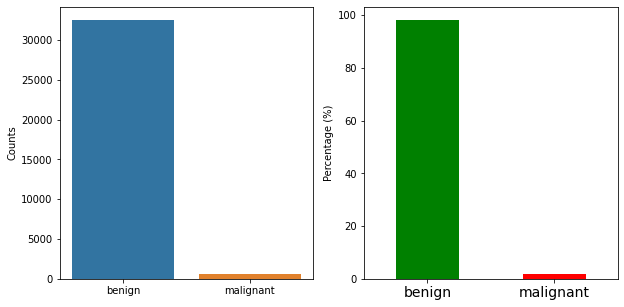

In [9]:
print("Number and percentage of benign and malignant")
print(df.target.value_counts())
print(df.target.value_counts()*100/df.target.count())

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
x = df.target.replace(to_replace=[0, 1], value=['benign','malignant'])
g1=sns.countplot(x=x,ax=ax[0])
g1.set(ylabel='Counts')
#g1.set(title='Count plot of lesion images')
g1.set(xlabel=None)


y=x.value_counts()*100/len(df.target)
g2=y.replace(to_replace=[0, 1], value=['benign','malignant']).plot(kind='bar', color=('g', 'r'))
plt.ylabel('Percentage (%)')
#plt.title('Percentage of lesion image')
g2.set_xticklabels(g2.get_xticklabels(), rotation=0,size=14)
plt.show()




In [10]:
df.sex.value_counts()

male      17080
female    15981
Name: sex, dtype: int64

target      0    1
sex               
female  15761  220
male    16716  364
 
target          0         1
sex                        
female  98.623365  1.376635
male    97.868852  2.131148


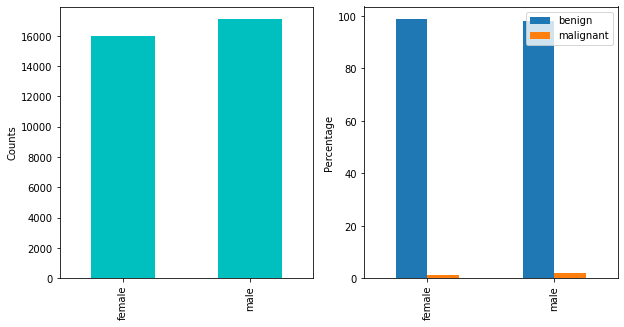

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
freq_df = df.groupby(['sex'])['target'].value_counts().unstack()

print(freq_df)
print(" ")
ax1=freq_df.plot(kind="bar", stacked=True,ax=ax[0],color=['c'],legend=False)

ax1.set_xlabel(None)

ax1.set_ylabel('Counts')
#ax1.set_title('image count in sex')



pct_df = freq_df.divide(freq_df.sum(axis=1)/100, axis=0)
print(pct_df)
ax2=pct_df.plot(kind="bar", stacked=False,ax=ax[1])
ax2.set_xlabel(None)
ax2.set_ylabel('Percentage')
#ax2.set_title('image percentage in sex')
ax2.legend(['benign', 'malignant'])
plt.show()

In [12]:
df.anatom_site_general_challenge.value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

Text(0.5, 1.0, 'Malignant count vs anatomic location')

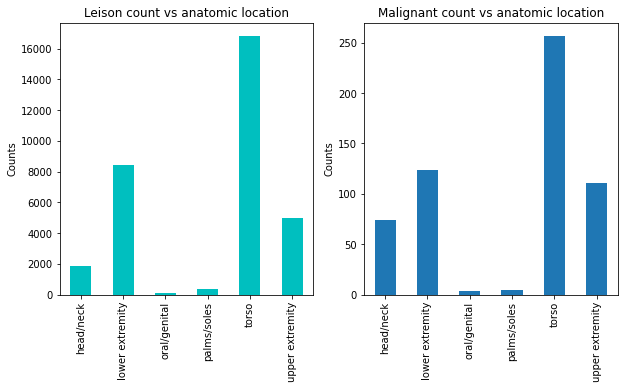

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
freq_df = df.groupby(['anatom_site_general_challenge'])['target'].value_counts().unstack()

ax1=freq_df.plot(kind="bar", stacked=True,ax=ax[0],color=['c'],legend=False)


ax1.set_xlabel(None)

ax1.set_ylabel('Counts')
ax1.set_title('Leison count vs anatomic location')

#pct_df = freq_df.divide(freq_df.sum(axis=1)/100, axis=0)
ax2=freq_df[1].plot(kind="bar", stacked=False,ax=ax[1],legend=None)
ax2.set_xlabel(None)
ax2.set_ylabel('Counts')
ax2.set_title('Malignant count vs anatomic location')
#ax2.legend(None)


In [14]:
print("Unique patients:-",df.patient_id.nunique())


Unique patients:- 2056


In [15]:
print(df.patient_id.value_counts().head())
print(df.patient_id.value_counts().tail())

IP_4479736    115
IP_4382720    115
IP_7279968    115
IP_4938382    115
IP_0656529    114
Name: patient_id, dtype: int64
IP_9347165    3
IP_8124898    3
IP_3994830    3
IP_3557056    3
IP_8335299    2
Name: patient_id, dtype: int64


In [16]:
Id_image_count=[]

Id_melanoma_count=[]

print("Patient_id","Lesion images", "Menalonma images")
for i in df.patient_id.unique():
    count=df.target[df.patient_id==i].count()
    Id_image_count.append(count)
    
    counter=0
    
    df_ind=df[df.patient_id==i]
    for s in range(count):
        if (df_ind.target.iloc[s]==1):
            counter+=1
        
            
    if (counter>0):
        Id_melanoma_count.append(counter)
        print(i,count,counter)
    #else:
    #    Id_melanoma_count.append(0)
        
        

Patient_id Lesion images Menalonma images
IP_6890425 22 1
IP_9802602 14 1
IP_1264754 36 3
IP_3076695 11 1
IP_3397861 34 1
IP_1273286 14 2
IP_0135517 15 1
IP_1139701 102 1
IP_0825081 58 1
IP_9751397 18 1
IP_7252102 53 1
IP_0962375 42 2
IP_2501903 27 1
IP_7770500 29 1
IP_0998852 23 1
IP_3675183 6 1
IP_1395856 21 1
IP_3623410 29 1
IP_9086201 20 4
IP_6118207 19 1
IP_6512345 85 1
IP_4387709 48 2
IP_6648913 21 2
IP_9042814 14 1
IP_1697215 37 1
IP_7100012 27 2
IP_7373371 42 8
IP_7665112 8 1
IP_7330399 101 1
IP_6459335 22 1
IP_8171851 27 3
IP_3523549 13 1
IP_5474292 50 2
IP_3089004 19 1
IP_6940325 19 1
IP_4116267 35 1
IP_2881084 7 1
IP_8375879 17 1
IP_5715797 22 2
IP_4745288 19 1
IP_8349964 31 2
IP_0775515 17 1
IP_6049920 35 2
IP_8738175 39 2
IP_6776978 65 1
IP_6067392 15 3
IP_8041141 52 1
IP_7735373 17 1
IP_9102359 16 1
IP_7375528 16 1
IP_0358262 15 1
IP_0232771 13 1
IP_0634841 22 1
IP_5550558 11 1
IP_1197949 76 2
IP_6293754 15 1
IP_2520657 18 1
IP_8326844 40 2
IP_7645011 11 1
IP_1480975 23 1

Text(0.5, 1.0, 'Box plot showing maelanoma images of patient')

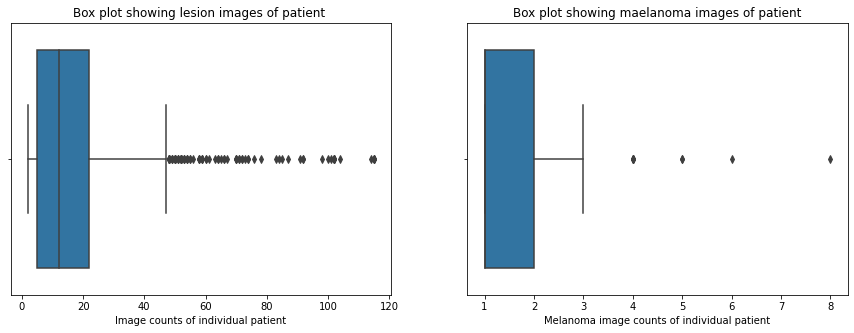

In [17]:
import seaborn as sns
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.boxplot(x=Id_image_count)
plt.xlabel('Image counts of individual patient')
plt.title('Box plot showing lesion images of patient ')

plt.subplot(1,2,2)
sns.boxplot(x = Id_melanoma_count)
#plt.ylabel('Counts')
plt.xlabel('Melanoma image counts of individual patient')
plt.title('Box plot showing maelanoma images of patient')


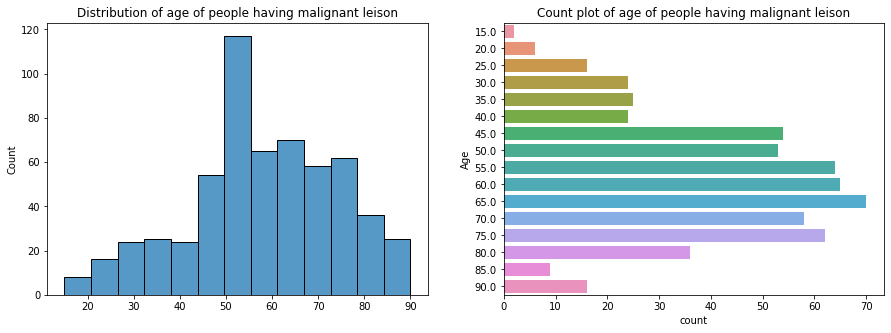

In [18]:
age = []
for i in range(df.shape[0]):
    try: 
        if df['target'].iloc[i] == 1:
            age.append(df['age_approx'].iloc[i]) 
    except:
        pass
    
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(age)
plt.title('Distribution of age of people having malignant leison')
plt.subplot(1,2,2)
sns.countplot(y = age)
plt.ylabel('Age')
plt.title('Count plot of age of people having malignant leison')
plt.show()

In [19]:
from pydicom import dcmread
from skimage import data, color

def dicom_to_array(filename):
    d = dicom.read_file(filename)
    a = d.pixel_array
    return a,d

In [20]:
#select balanced data set to visualize both images
import random
seed=5
s0 = df.target[df.target.eq(0)].sample(50,random_state=seed).index
s1 = df.target[df.target.eq(1)].sample(50,random_state=seed).index
#print(s0)
#print(s1)
df= df.loc[s0.union(s1)]
df['target'].value_counts()

1    50
0    50
Name: target, dtype: int64

In [21]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
158,ISIC_0167093,IP_8029095,female,45.0,upper extremity,unknown,benign,0
1817,ISIC_0647224,IP_5064161,male,30.0,lower extremity,melanoma,malignant,1
2693,ISIC_0906053,IP_2577172,female,65.0,lower extremity,unknown,benign,0
2856,ISIC_0953317,IP_2278509,male,65.0,torso,melanoma,malignant,1
3119,ISIC_1037315,IP_0623861,male,60.0,lower extremity,melanoma,malignant,1


<class 'pydicom.dataset.FileDataset'>
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7658.1003.1589903823523.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SO

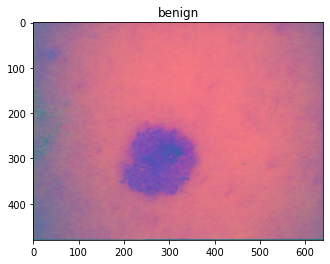

image size:- (480, 640, 3)
smallest intensity:- 0
largest intensity:- 250
   
<class 'pydicom.dataset.FileDataset'>
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7658.1003.1589903823523.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class 

In [22]:
from pydicom import dcmread
from skimage import data, color

index=0

image ='train/'+df['image_name'].iloc[index] +'.dcm'
ds = dicom.dcmread(image)
ds = dcmread(image)
print(type(ds))
print(ds)
#plt.imshow(ds.pixel_array)



def dicom_to_array(filename):
    d = dicom.read_file(filename)
    a = d.pixel_array
    return a,d
    #return np.array(a),d


a1,d = dicom_to_array(image)
plt.title(df['benign_malignant'].iloc[index])
plt.imshow(a1)
plt.show()
print("image size:-",a1.shape)
print("smallest intensity:-", np.ndarray.min(a1) )
print("largest intensity:-", np.ndarray.max(a1) )
print("   ")
print(type(d))
print(d)


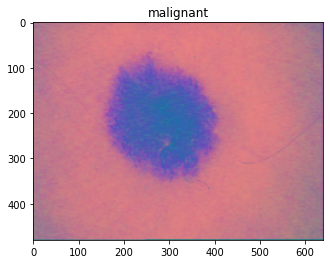

(0018, 0015) Body Part Examined                  CS: 'LOWER EXTREMITY'
image size:- (480, 640, 3)
smallest intensity:- 2
largest intensity:- 242


In [23]:
index=1

image ='train/'+df['image_name'].iloc[index] +'.dcm'

a1,d = dicom_to_array(image)
plt.title("Malignant")
#plt.axis('off')
plt.imshow(a1)
plt.title(df['benign_malignant'].iloc[index])
plt.show()


print(d['BodyPartExamined'])
print("image size:-",a1.shape)
print("smallest intensity:-", np.ndarray.min(a1) )
print("largest intensity:-", np.ndarray.max(a1) )

#print(type(d))
#print(d)
#print(d.file_meta)


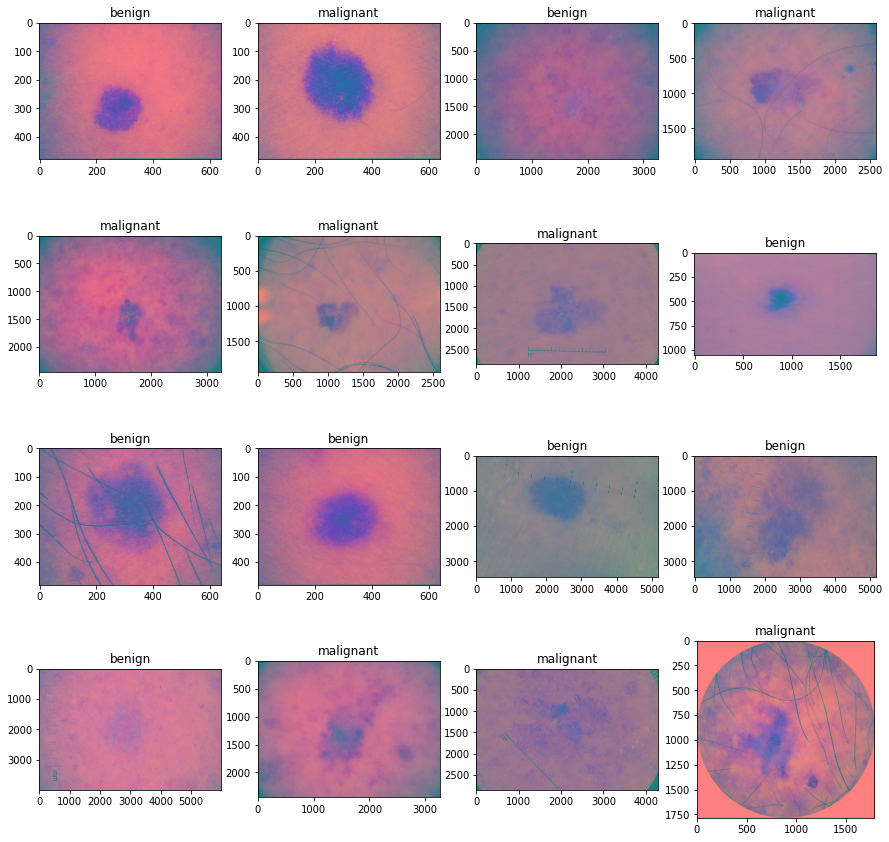

In [24]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = image ='train/'+df['image_name'].iloc[i] +'.dcm'
    a1,d = dicom_to_array(image)
      # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    ax[-1].set_title(df['benign_malignant'].iloc[i])

    plt.imshow(a1)

